<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/Lower_imgs_AF_classification_EfficientNetB0_with_trainable_params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import datetime
import tensorflow_hub as hub
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
from TF_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_image

--2022-12-02 20:49:16--  https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10747 (10K) [text/plain]
Saving to: ‘TF_functions.py’

TF_functions.py     100%[===================>]  10.50K  --.-KB/s    in 0s      

2022-12-02 20:49:16 (110 MB/s) - ‘TF_functions.py’ saved [10747/10747]



image shape: (150, 150, 3)


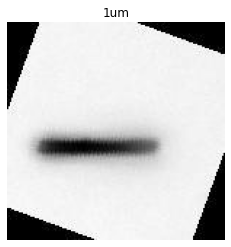

In [4]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/python_torturial/NW_depth_5NWs_negative_side.zip","r")
zip_ref.extractall()
zip_ref.close()

# Setup the train and test directories
train_dir = "NW_depth_5NWs_negative_side/training/"
test_dir = "NW_depth_5NWs_negative_side/testing/"

# visualize
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

img = view_random_image(target_dir=train_dir,
              target_class=random.choice(class_names))

In [5]:
IMAGE_SIZE = (150,150)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                        image_size=IMAGE_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                  image_size=IMAGE_SIZE,
                                  label_mode="categorical",
                                  batch_size=32,
                                  shuffle=True)

Found 2790 files belonging to 9 classes.
Found 450 files belonging to 9 classes.


In [6]:
# create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    #preprocessing.RandomFlip("horizontal"),
    #preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
#    preprocessing.Rescaling(1./255) need for resnet but not for efficientnet
],name="data_augmentation")

NW_depth_5NWs_negative_side/training/5um
NW_depth_5NWs_negative_side/training/5um/wire_data-5-3-8.jpeg


Text(0.5, 1.0, 'Augmented random image from: 5um')

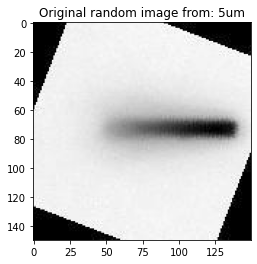

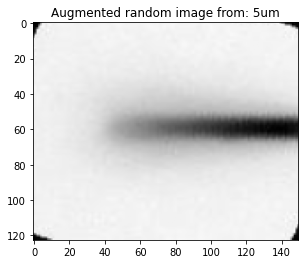

In [7]:
# view a random image and compare it to its augmented version
target_class = random.choice(train_data.class_names)
target_dir = "NW_depth_5NWs_negative_side/training/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from: {target_class}")

# Let's plot augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from: {target_class}")

In [8]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Check the layers in our base model
#for layer_number, layer in enumerate(base_model.layers):
#  print(layer_number, layer.name)

# The model contains a noramlization and rescaling layer

# 2. Free the base model (the underlying pre-trained patterns aren't updated during training)
base_model.trainable = True

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(150,150,3),name="input_layer")
# Add in data augmentation sequential model as a layer
# x = data_augmentation(inputs)

# 4. If using a model like ResNet50V2, you will need to noramlize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(9,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
        optimizer = Adam(learning_rate=0.001),
        metrics=["accuracy"])

# 10. Fit the model and save the history
history_0 = model_0.fit(train_data,
                  epochs=100,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=len(test_data),
                  callbacks=[create_tensorboard_callback(dir_name="EfficientNetB0",
                                      experiment_name="EfficientNetB0_test1")])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: EfficientNetB0/EfficientNetB0_test1/20221202-205037
Epoch 1/100
88/88 [==============================] - 29s 129ms/step - loss: 0.9497 - accuracy: 0.6470 - val_loss: 2.0838 - val_accuracy: 0.3444
Epoch 2/100
88/88 [==============================] - 10s 108ms/step - loss: 0.3379 - accuracy: 0.8645 - val_loss: 1.8596 - val_accuracy: 0.2978
Epoch 3/100
88/88 [==============================] - 10s 108ms/step - loss: 0.2460 - accuracy: 0.8982 - val_loss: 2.8862 - val_accuracy: 0.1933
Epoch 4/100
88/88 [==============================] - 10s 112ms/step - loss: 0.2214 - accuracy: 0.9025 - val_loss: 2.1125 - val_accuracy: 0.4356
Epoch 5/100
88/88 [==============================] - 10s 111ms/step - loss: 0.1959 - accuracy: 0.9147 - val_loss: 1.5777 - val_accuracy: 0.5711
Epoch 6/100
88/88 [==============================] - 10s 113ms/step - loss: 0.1178 - accuracy: 0.9366 - val_loss: 2.4814 - val_acc

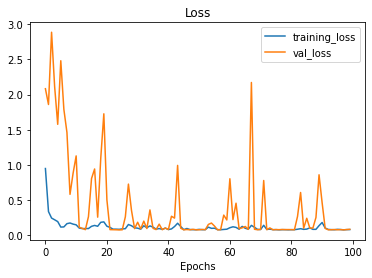

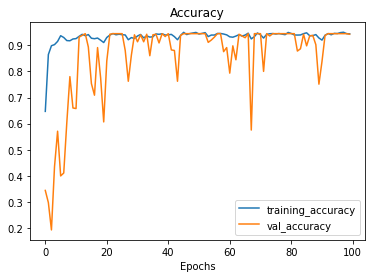

In [9]:
plot_loss_curves(history_0)

In [23]:
import itertools
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [24]:
y_probs = model_0.predict(test_data) # "probs" is short for probabilities
y_pred = y_probs.argmax(axis = 1)
y_pred

4/4 [==============================] - 1s 13ms/step


array([0, 4, 2, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 3, 4, 4, 2, 1, 4,
       3, 2, 0, 2, 3, 2, 2, 2, 2, 3, 0, 4, 1, 2, 0, 0, 0, 2, 4, 4, 0, 0,
       2, 0, 2, 2, 4, 3, 0, 2, 2, 0, 0, 1, 3, 3, 4, 0, 2, 3, 2, 4, 4, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 4, 0, 0, 0, 2, 3, 1, 2, 0, 2, 0, 2, 2, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 3, 3, 2, 0])

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=class_names, 
        y_pred=y_pred)

ValueError: ignored

In [ ]:
# save model
model_0.save('efficientnetB0_nw_pitch_angle.h5')
print('Model Saved!')
# load model
# savedModel=load_model('gfgModel.h5')
# savedModel.summary()

Model Saved!


In [ ]:
model_0.evaluate(test_data)

94/94 [==============================] - 2s 16ms/step - loss: 0.0011 - accuracy: 0.9993


[0.0011001199018210173, 0.9993297457695007]